In [13]:
# Filtering out the warnings.
import warnings
warnings.filterwarnings('ignore')

In [1]:
# Importing the required libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.tsa.stattools as adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import pmdarima as pm
from keras.models import Sequential
from keras.layers import Dense , LSTM , Dropout , Bidirectional
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
plt.style.use('seaborn-darkgrid')
%matplotlib inline

C:\Users\JW\AppData\Local\Temp\ipykernel_9940\2989588899.py:19: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


In [2]:
# Importing the Dataset.
stock=pd.read_csv("dataset.csv")
stock.Date = pd.to_datetime(stock.Date, format='%Y%m%d', errors='ignore')
cols = ['Symbol','Series','Prev Close','Open','High', 'Low','Last','VWAP','Volume','Turnover','Trades','Deliverable Volume','%Deliverble']
stock.drop(cols, axis=1, inplace=True)
stock = stock.sort_values('Date')
stock = stock.groupby('Date')['Close'].sum().reset_index()
stock = stock.set_index('Date')
stock.index = pd.to_datetime(stock.index)
monthly_mean = stock.Close.resample('M').mean()
print(monthly_mean)
# Checking the data.
stock.head()

Date
2007-11-30     915.637500
2007-12-31    1105.776316
2008-01-31    1021.645652
2008-02-29     752.285714
2008-03-31     570.563889
                 ...     
2020-12-31     465.236364
2021-01-31     520.632500
2021-02-28     617.855000
2021-03-31     718.066667
2021-04-30     756.023684
Freq: M, Name: Close, Length: 162, dtype: float64


,Close
Date,
2007-11-27,962.90
2007-11-28,893.90
2007-11-29,884.20
2007-11-30,921.55
2007-12-03,969.30


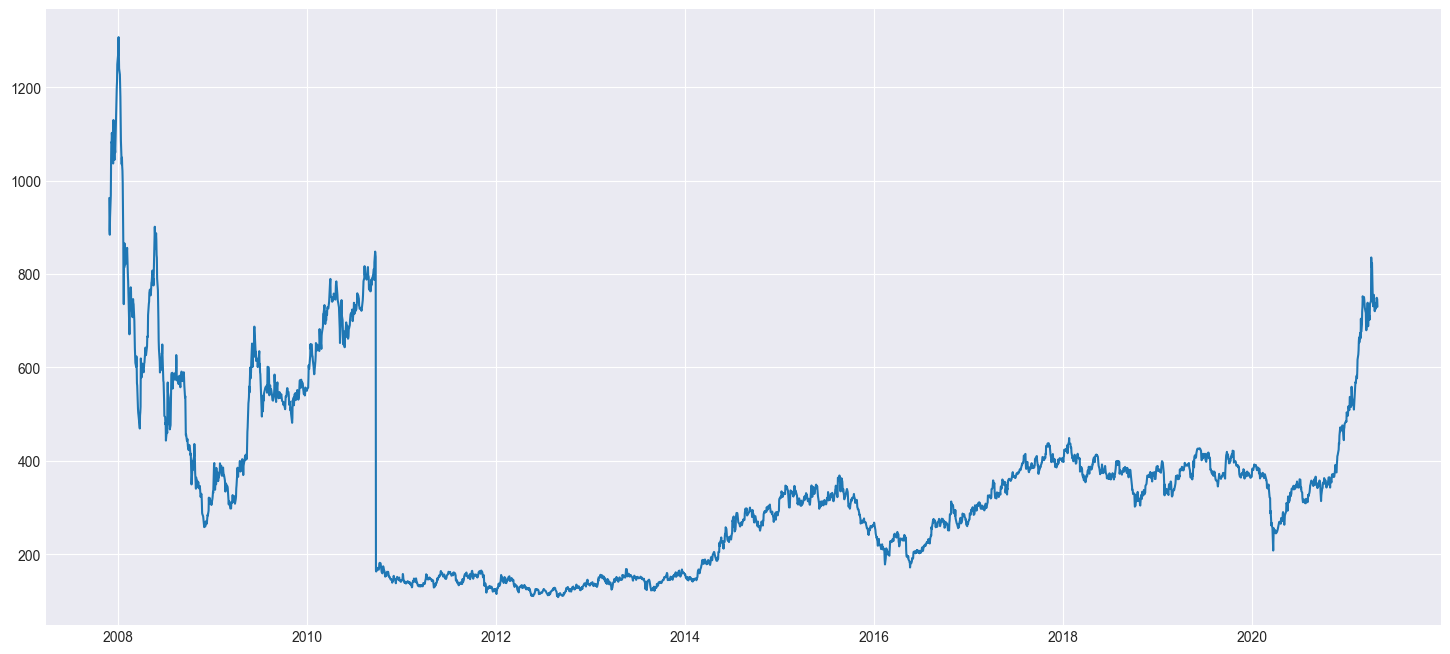

In [3]:
# Plotting a simple chart to visualize the price.
plt.figure(figsize=(18,8))
plt.plot(stock.Close)
plt.show()

In [4]:
#spilt the dataset
train_data, test_data = stock[0:int(len(stock)*0.7)], stock[int(len(stock)*0.7):]
training_data = train_data['Close'].values
test_data = test_data['Close'].values

In [5]:
#arima model
model2=pm.auto_arima(training_data,  trace=True, 
                     error_action="ignore", 
                     suppress_warnings=True)
# Fitting the model based on train data.
model2.fit(training_data)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=20254.477, Time=3.84 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=20253.512, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=20250.080, Time=0.35 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=20250.210, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=20251.992, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=20251.763, Time=0.44 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=20251.769, Time=0.73 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=20253.728, Time=1.10 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=20248.520, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=20250.193, Time=0.24 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=20250.199, Time=0.32 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=20248.651, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=20252.158, Time=0.43 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 8.203 seconds


ARIMA(order=(1, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [6]:
# Developing a function to forecast the next day price using the previous day price.
def forecast_one_step():
    forecast, conf_int = model2.predict(n_periods=1, return_conf_int=True)
    return (
        forecast.tolist()[0],
        np.asarray(conf_int).tolist()[0])

y_pred = []
y_confidence = []
y_fc=[]
for i, new_ob in enumerate(test_data):
# Implementing the function
    fc, conf = forecast_one_step()
# Appending the preditions to 'y_pred'
    y_pred.append(fc)
# Appending the confidence intervals to 'y_confidence'
    y_confidence.append(conf)
# Printing the output
    #print(i, fc, new_ob, abs(fc - new_ob))
# Updating the model with everytime it predicts the next day price.
    model2.update(new_ob)
    

              col1    col2
Date                      
2017-04-21  446.00  326.00
2017-04-24  451.00  331.00
2017-04-25  451.35  331.35
2017-04-26  443.50  323.50
2017-04-27  442.50  322.50
...            ...     ...
2021-04-26  850.75  730.75
2021-04-27  869.15  749.15
2021-04-28  866.25  746.25
2021-04-29  866.75  746.75
2021-04-30  850.05  730.05

[997 rows x 2 columns]


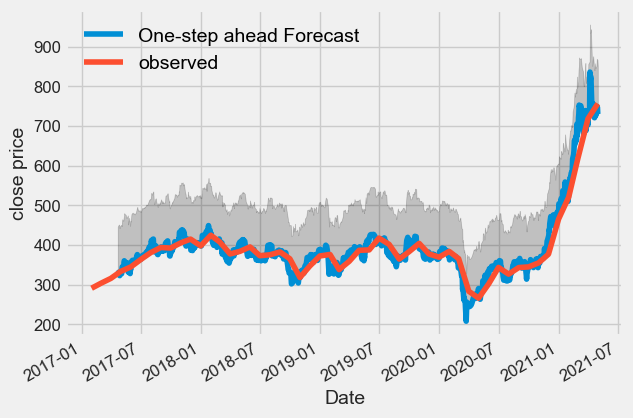

In [54]:
#Dataframe->list
import matplotlib
import numpy as np
diff=120
plt.style.use('fivethirtyeight')
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
t_d=[]
for i in range(int(len(test_data))):
    t_d.append(test_data[i]+diff)
#Create dataframe   
d = {'col1': t_d, 'col2': y_pred}
df = pd.DataFrame(data=d)
print(df)
data = stock.filter(['Close'])
train = data[:int(len(stock)*0.7)]
test=stock[int(len(stock)*0.7):]
validation = data[int(len(stock)*0.7):]
#Plot compare prediction value with average value

plt.plot(y_pred,label='One-step ahead Forecast')
ax = monthly_mean['2017':].plot(label='observed')
ax.fill_between(test.index,
                df.iloc[:, 0],
                df.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('close price')
plt.legend()
plt.show()
#############

In [55]:
# Evaluating the prediciton using RMSE, MAE, RMPE and R2 score.
import numpy as np
print('Root Mean Square Error:', np.sqrt(mean_squared_error(test_data, y_pred)/len(test_data)))
print('Mean Absolute Error:', mean_absolute_error(test_data, y_pred))
print('MAPE:', np.mean(np.abs(y_pred-test_data)/np.abs(test_data)))
print('R-Squared', r2_score(test_data, y_pred))

Root Mean Square Error: 0.0
Mean Absolute Error: 0.0
MAPE: 0.0
R-Squared 1.0


In [56]:
y_pred1 = []
y_confidence1 = []
y_fc1=[]

for i, new_ob1 in enumerate(test_data[900:]):
# Implementing the function
    fc1, conf1 = forecast_one_step()
# Appending the preditions to 'y_pred'
    y_pred1.append(fc1)
# Appending the confidence intervals to 'y_confidence'
    y_confidence1.append(conf1)
# Printing the output
    print(i, fc1, new_ob1, abs(fc1 - new_ob1))
# Updating the model with everytime it predicts the next day price.
    model2.update(new_ob1)
print(y_pred1)    

0 729.3864185390357 463.35 266.0364185390357
1 451.5902298917682 463.9 12.30977010823176
2 463.9225949646983 471.0 7.077405035301695
3 471.29247134920473 466.3 4.99247134920472
4 466.10708861907466 467.0 0.8929113809253408
5 467.02873438177267 475.75 8.721265618227335
6 476.1094379151973 475.55 0.559437915197293
7 475.541793762302 467.75 7.791793762302007
8 467.42923918393313 463.3 4.129239183933123
9 463.11743097199707 444.25 18.867430971997067
10 443.46594566319465 468.65 25.184054336805332
11 469.6435127618432 470.75 1.1064872381567739
12 470.83556378325324 478.55 7.714436216746776
13 478.86800051822627 483.55 4.681999481773744
14 483.75411007622733 483.4 0.35411007622735724
15 483.39388842212753 485.4 2.0061115778724457
16 485.4817092389624 483.75 1.7317092389624236
17 483.6827948131647 503.85 20.167205186835304
18 504.6692502987712 498.9 5.769250298771226
19 498.69875121702097 499.45 0.7512487829790189
20 499.47232547184535 496.8 2.6723254718453404
21 496.6922235732663 513.85 17.1

In [104]:
print(len(y_pred1))

units = y_pred1
new_list = [x+150 for x in y_pred1]
begin_date = '2021-5-1'
pred_df=pd.DataFrame({'Date':pd.date_range(begin_date, periods=len(units)),
                   'Close':units,'pred':new_list
                   })
pred_df = pred_df.sort_values('Date')
pred_df = pred_df.set_index('Date')
print(pred_df)
df1 = pd.DataFrame({'Date':pd.date_range(begin_date, periods=len(units)),
                   'Close':units,
                   })
df1 = df1.sort_values('Date')
df1 = df1.groupby('Date')['Close'].sum().reset_index()
df1 = df1.set_index('Date')
df1.index = pd.to_datetime(df1.index)
frames = [test, df1]
result = pd.concat(frames)
result=result.iloc[97:,:]
result = result.sort_values('Date')
result = result.groupby('Date')['Close'].sum().reset_index()
result = result.set_index('Date')
result.index = pd.to_datetime(result.index)
monthly_mean = result.Close.resample('M').mean()

97
                 Close        pred
Date                              
2021-05-01  729.386419  879.386419
2021-05-02  451.590230  601.590230
2021-05-03  463.922595  613.922595
2021-05-04  471.292471  621.292471
2021-05-05  466.107089  616.107089
...                ...         ...
2021-08-01  724.855578  874.855578
2021-08-02  730.964106  880.964106
2021-08-03  749.881238  899.881238
2021-08-04  746.134956  896.134956
2021-08-05  746.769837  896.769837

[97 rows x 2 columns]


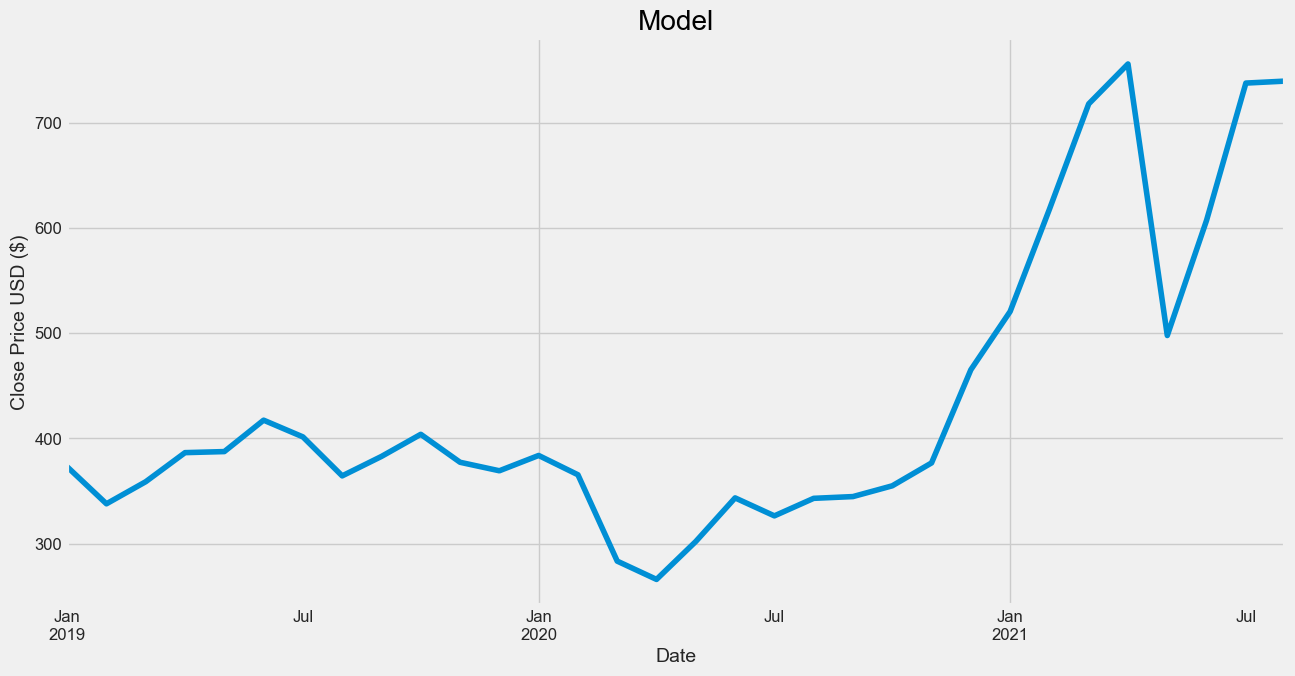

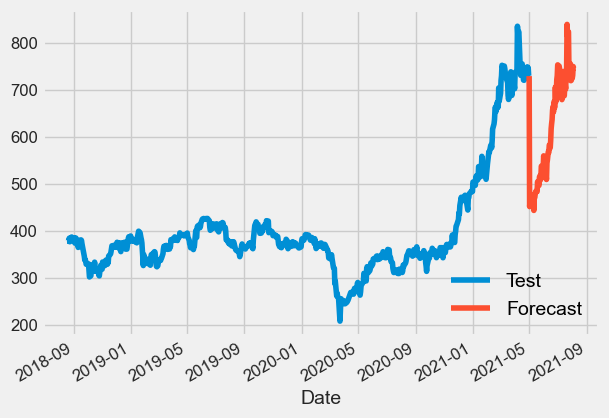

In [115]:
#spilt the dataset
train_data, test_data = stock[0:int(len(stock)*0.7)], stock[int(len(stock)*0.7):]
training_data = train_data['Close'].values
test_data = test_data['Close'].values
data = stock.filter(['Close'])
train = data[:int(len(stock)*0.8)]
test = data[int(len(stock)*0.8):]
pred = df1['Close']
plt.figure(figsize=(14,7))
ax = monthly_mean.plot(label='observed', figsize=(14, 7))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
test.plot(label='Test')
pred.plot(label='Forecast')
plt.legend(['Test','Forecast'], loc='lower right')
plt.show()